<AxesSubplot: >

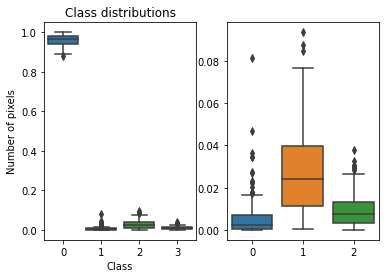

In [1]:
#Boxplot of distributions
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
dir = Path.home() / 'Documents' / 'DTU' / 'E23' / '02456_Deep_Learning' / 'Brain_Project' / 'BRaTS_UNET'
distributions = np.load(dir / 'class_distributions.npy')
avg_distributions = distributions/np.sum(distributions, axis=1)[:,None]
#Plot histrogram for every patient on top of each other
plt.subplot(1,2,1)
#Histogram
#plt.hist(np.sum(distributions,axis=0), bins=100)
sns.boxplot(data=avg_distributions)
plt.title('Class distributions')
plt.xlabel('Class')
plt.ylabel('Number of pixels')

plt.subplot(1,2,2)
#plot last 3 classes
sns.boxplot(data=avg_distributions[:,1:])

In [2]:
import nibabel as nib
from pathlib import Path
import torch
extensions = ['flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'seg.nii.gz']
patient_id = 'BraTS2021_00495'
patient_dir = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/Brain_Project/BRaTS_UNET/data/archive/BraTS2021_00495'))
data = [nib.load(str(patient_dir / f'{patient_id}_{ext}')).get_fdata() for ext in extensions]

: 

In [ ]:
label = data[-1]
data = 
print(label.shape)
print(data.shape)